We are interested in finding a control of the nonlinear system (1.7):
\begin{equation}
		\left\{
		\begin{aligned}
			&h(t)\psi_{t}-\psi_{xx} - \frac{x}{2}h^{\prime}(t)\psi_{x}-h(t)\psi(1-\psi) =0 & & \text {in}\; Q, \\
			& \psi_{x}(0,t)=u(t)  & & \text {in}\;(0,T), \\
			& \psi(1,t)=0 & & \text {in}\;(0,T), \\
			&h^{\prime}(t)+2\mu \psi_{x}(1,t)=0 & & \text {in}\;(0,T),  \\
			& h(0)=h_{0}\\
			& \psi(\cdot,0)=\psi_{0} & &\text {in}\;(0,1),
		\end{aligned}
		\right.
	\end{equation}
	such that
	$$\psi(x,T)=0, ∀ x\in (0,1), \;\; and\;\; h(T)=0$$
We consider the following data:

$L=1$, $T=1$, $h_0=0.5$, $\psi_0(x)=\sin(\pi x)$ for $0\leq x\leq L$. 


In [153]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Parameters

In [154]:
# Parameters
mu = 0.5  # Coefficient in the dynamic condition
L = 1    # Spatial domain (-1, 1)
T = 1   # Time domain (0, T)

delta = 1e-6 # to avoid singularities


### Networks for the state and control variables

In [155]:
# Network for the state z(x,t)
psi_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    #tf.keras.layers.Dense(50, activation='tanh'),
    #tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Network for the state k(t)
h_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((1,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])

# Network for the control v(x,t)
u_net = tf.keras.Sequential([
    tf.keras.layers.InputLayer((2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])


### Dataset for training and test (Training and test points)

In [156]:
# training: random points that follow a uniform distribution
N_x_training = 1000
N_t_training = 1000

x_sample_training = tf.random.uniform((N_x_training, 1), 0, L) # spatial interval (0, L)
t_sample_training = tf.random.uniform((N_t_training, 1), 0, T)  # time interval (0, T)
xt_sample_training = tf.concat([x_sample_training, t_sample_training], axis=1) # (0, L) x (0, T)
x_one_t_sample_training = tf.concat([tf.ones_like(t_sample_training), t_sample_training], axis=1) # x=1, 0<t<T
x_0_t_sample_training = tf.concat([tf.zeros_like(t_sample_training), t_sample_training], axis=1)  # x=0, 0<t<T

# test points
N_x_test = 100
N_t_test = 100

x_sample_test = tf.random.uniform((N_x_test, 1), 0, L)
t_sample_test = tf.random.uniform((N_t_test, 1), 0, T)
xt_sample_test = tf.concat([x_sample_test, t_sample_test], axis=1)
x_one_t_sample_test = tf.concat([tf.ones_like(t_sample_test), t_sample_test], axis=1)
x_0_t_sample_test= tf.concat([tf.zeros_like(t_sample_test), t_sample_test], axis=1)


### Losses for the ODE-PDE system

In [157]:
# initial conditions for z and k

def psi_0(x): 
    return tf.sin(np.pi * x)

def loss_psi_0(sample_points):
    psi_init_pred = psi_net(tf.concat([sample_points, tf.zeros_like(sample_points)], axis=1))
    return tf.reduce_mean(tf.square(psi_init_pred - psi_0(sample_points)))
print(loss_psi_0(x_sample_training))

h_0 = 0.5

def loss_k_0(k_0):
    t_init = tf.zeros((100, 1))
    h_init_pred = h_net(t_init)    
    return tf.sqrt(tf.reduce_mean(tf.square(h_init_pred - h_0)) + delta)

loss_k_0(h_0)

tf.Tensor(0.66074383, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.500001>

In [158]:
# final conditions

def loss_z_T(sample_points):
  psi_T_predict = psi_net(tf.concat([sample_points, T * tf.ones_like(sample_points)], axis=1))
  return tf.reduce_mean(tf.square(psi_T_predict)) # \psi(x, T)=0
print(loss_z_T(x_sample_training))


def loss_k_T(t_final): 
  t_final = t_final * np.ones((100, 1))
  h_final_pred = h_net(t_final)
  return tf.sqrt(tf.reduce_mean(tf.square(h_final_pred)) + delta) #k(T)=0 
loss_k_T(T)

tf.Tensor(0.09495808, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.08374132>

In [ ]:

def loss_boundary_0(sample_points):
    x_zero_t_sample = tf.concat([tf.zeros_like(sample_points), sample_points], axis=1)
    # Computation of \psi_x(0,t)
    with tf.GradientTape(persistent=True) as tape3:
        tape3.watch(x_zero_t_sample)
        u_pred = u_net(x_zero_t_sample)
        psi_pred_boundary0 = psi_net(x_zero_t_sample)
        psi_x_boundary0 = tape3.gradient(psi_pred_boundary0, x_zero_t_sample)[:, 0:1]
    return tf.reduce_mean(tf.square(u_pred-psi_x_boundary0))
print(loss_boundary_0(t_sample_training))
def loss_boundary_1(sample_points):
    x_one_t_sample = tf.concat([tf.ones_like(sample_points), sample_points], axis=1)  # points (1, t)
    psi_boundary1_pred = psi_net(x_one_t_sample)
    return tf.reduce_mean(tf.square(psi_boundary1_pred))

print(loss_boundary_1(t_sample_training))




tf.Tensor(0.06406825, shape=(), dtype=float32)
tf.Tensor(0.014267247, shape=(), dtype=float32)


In [160]:
# constraint z>=0

def smooth_max(x1, x2, beta=10):
    return (1.0 / beta) * tf.math.log(tf.exp(beta * x1) + tf.exp(beta * x2))

x_1 = tf.constant([0.])
def loss_z_non_negative(sample_points):
    return tf.reduce_mean(smooth_max(x_1, - psi_net(sample_points)))
loss_z_non_negative(xt_sample_training)


<tf.Tensor: shape=(), dtype=float32, numpy=0.050286897>

In [161]:
# PDE: h(t) * psi_t - psi_xx - (x / 2) * h'(t) * psi_x - h(t) * psi * (1 - psi) = 0
   

def loss_pde(spatial_time_points, time_points):
        x_sample = spatial_time_points[:, 0]

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(spatial_time_points)
            psi_pred = psi_net(spatial_time_points)
            psi_x = tape.gradient(psi_pred, spatial_time_points)[:, 0:1]
            psi_t = tape.gradient(psi_pred, spatial_time_points)[:, 1:2]
            psi_xx = tape.gradient(psi_x, spatial_time_points)[:, 0:1]
        with tf.GradientTape(persistent=True) as tape5:
            tape5.watch(time_points)
            h_pred = h_net(time_points)
            h_t_predict = tape5.gradient(h_pred, time_points)[:, 0:1]             
        
        #return tf.reduce_mean(tf.square(h_pred * psi_t - psi_xx - (x_sample / 2) * tf.gradients(h_pred, time_points)[0] * psi_x - h_pred * psi_pred * (1 - psi_pred)))
        return tf.reduce_mean(tf.square(h_pred * psi_t - psi_xx - (x_sample / 2) * h_t_predict * psi_x - h_pred * psi_pred * (1 - psi_pred)))
        
loss_pde(xt_sample_training, t_sample_training)  

<tf.Tensor: shape=(), dtype=float32, numpy=0.0014021652>

In [162]:
# ODE: h^{\prime}(t)+2\mu \psi_{x}(1,t)=0
def loss_ode(time_points):
    one_t_points = tf.concat([tf.ones_like(time_points), time_points], axis=1)
    with tf.GradientTape() as tape2:
      tape2.watch(one_t_points)      
      psi_pred_boundary = psi_net(one_t_points)
      psi_x_boundary = tape2.gradient(psi_pred_boundary, one_t_points)[:, 0:1]
    with tf.GradientTape() as tape3:
       tape3.watch(time_points)
       h_predict = h_net(time_points)
       h_t = tape3.gradient(h_predict, time_points)[:, 0:1]

    return tf.reduce_mean(tf.square(h_t + 2 * mu * psi_x_boundary))
    
loss_ode(t_sample_training)

<tf.Tensor: shape=(), dtype=float32, numpy=0.02140572>

In [163]:
# total loss function
def loss_add(sample_points, k_0, x_sample_points, t_sample_points, t_final):
    loss_init_z = loss_psi_0(x_sample_points)
    loss_init_k = loss_k_0(h_0)
    loss_final_z = loss_z_T(x_sample_points)
    loss_final_k = loss_k_T(t_final)    
    loss_pde_z = loss_pde(sample_points, t_sample_points)
    loss_dyn_k = loss_ode(t_sample_points)
    loss_boundary0 = loss_boundary_0(t_sample_points)
    loss_boundary1 = loss_boundary_1(t_sample_points)
    loss_z_constraint = loss_z_non_negative(sample_points)
    loss_total = 10 * loss_init_z + 10 * loss_init_k + 10 * loss_final_z + 10 * loss_final_k  + 0.001 * loss_boundary0 + 20 * loss_boundary1 + 15 * loss_pde_z + 15 * loss_dyn_k + 60 * loss_z_constraint
    
    return loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde_z, loss_dyn_k, loss_boundary0, loss_boundary1, loss_z_constraint
    
loss_add(xt_sample_training, h_0, x_sample_training, t_sample_training, T)



(<tf.Tensor: shape=(), dtype=float32, numpy=17.039185>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.66074383>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.500001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09495808>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08374132>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0014021652>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.02140572>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06406825>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.014267247>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.050286897>)

### Training



In [164]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step():
    with tf.GradientTape() as tape4:
        loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde_z, loss_dyn_k, loss_boundary0, loss_boundary1, loss_z_constraint =  loss_add(
            xt_sample_training, h_0, x_sample_training, t_sample_training, T
            )                          
    gradients = tape4.gradient(loss_total, psi_net.trainable_variables + h_net.trainable_variables + u_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, psi_net.trainable_variables + h_net.trainable_variables + u_net.trainable_variables))
    loss_test, _, _, _, _, _, _, _, _, _ = loss_add(
            xt_sample_test, h_0, x_sample_test, t_sample_test, T
            ) 
    return loss_test, loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde_z, loss_dyn_k, loss_boundary0, loss_boundary1, loss_z_constraint
train_step()
    

(<tf.Tensor: shape=(), dtype=float32, numpy=15.34886>,
 <tf.Tensor: shape=(), dtype=float32, numpy=17.039185>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.66074383>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.500001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09495809>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.083741315>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0014021652>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.02140572>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06406826>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.014267249>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.050286897>)

In [165]:
epochs = 20000
iterations, loss_history_train, loss_history_test = list(), list(), list()

for epoch in range(epochs):
    loss_test, loss_total, loss_init_z, loss_init_k, loss_final_z, loss_final_k, loss_pde, loss_dyn_k, loss_boundary_0, loss_boundary_1, loss_z_constraint = train_step()
        
    if epoch % 1000 == 0:
        iterations.append(epoch)
        loss_history_train.append(loss_total)
        loss_history_test.append(loss_test)
        
        print(
            f"Epoch {epoch}: Loss_test = {loss_test.numpy():.4f}, Loss_total = {loss_total.numpy():.4f}, loss_init_z = {loss_init_z.numpy():.4f}, loss_init_k = {loss_init_k.numpy():.4f}, loss_final_z = {loss_final_z.numpy():.4f}, loss_final_k = {loss_final_k.numpy():.4f}, loss_pde = {loss_pde.numpy():.4f}, loss_dyn_k = {loss_dyn_k.numpy():.4f}, loss_boundary0 = {loss_boundary_0.numpy():.4f}, loss_boundary1 = {loss_boundary_1.numpy():.4f}, loss_z_constraint = {loss_z_constraint.numpy():.4f}"
            )
print(f"generalization error = {np.abs(loss_history_train[-1] - loss_history_test[-1])}")

Epoch 0: Loss_test = 14.1021, Loss_total = 14.8774, loss_init_z = 0.5711, loss_init_k = 0.4982, loss_final_z = 0.1254, loss_final_k = 0.0178, loss_pde = 0.0007, loss_dyn_k = 0.0308, loss_boundary0 = 0.0125, loss_boundary1 = 0.0189, loss_z_constraint = 0.0317
Epoch 1000: Loss_test = 5.9243, Loss_total = 6.0118, loss_init_z = 0.1227, loss_init_k = 0.0061, loss_final_z = 0.0136, loss_final_k = 0.0158, loss_pde = 0.0183, loss_dyn_k = 0.0626, loss_boundary0 = 0.0002, loss_boundary1 = 0.0969, loss_z_constraint = 0.0213
Epoch 2000: Loss_test = 5.3956, Loss_total = 5.4691, loss_init_z = 0.0745, loss_init_k = 0.0153, loss_final_z = 0.0102, loss_final_k = 0.0148, loss_pde = 0.0174, loss_dyn_k = 0.0793, loss_boundary0 = 0.0015, loss_boundary1 = 0.0813, loss_z_constraint = 0.0207
Epoch 3000: Loss_test = 5.1039, Loss_total = 4.9836, loss_init_z = 0.0439, loss_init_k = 0.0054, loss_final_z = 0.0082, loss_final_k = 0.0059, loss_pde = 0.0187, loss_dyn_k = 0.0755, loss_boundary0 = 0.0006, loss_boundary

### Post-processing

In [166]:
# using LaTeX in the pictures that follow
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for all text
    "font.family": "serif",  # Use serif font (default LaTeX style)
    "font.size": 12  # Adjust font size
})

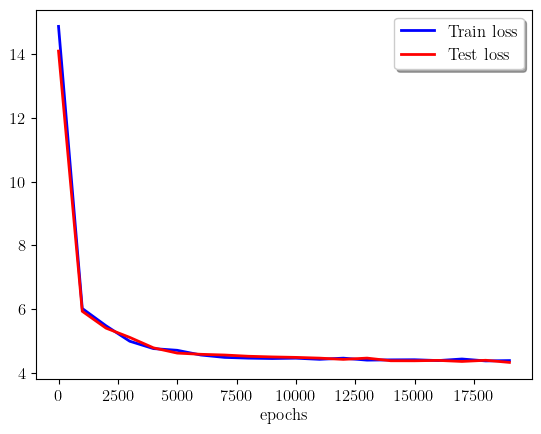

In [172]:
# convergence history

fig, ax = plt.subplots()
ax.plot(iterations, loss_history_train, '-', color='blue', linewidth=2, label=r'Train loss')
ax.plot(iterations, loss_history_test, '-', color='red', linewidth=2, label=r'Test loss')
ax.set(xlabel=r'epochs')
plt.legend(framealpha=1, shadow=True)
plt.savefig('../figures/nonlinear_convergence_history.pdf', format='pdf')
#plt.savefig('nonlinear_convergence_history.eps', format='eps')
plt.show()

1250/1250 [==============================] - 1s 441us/step


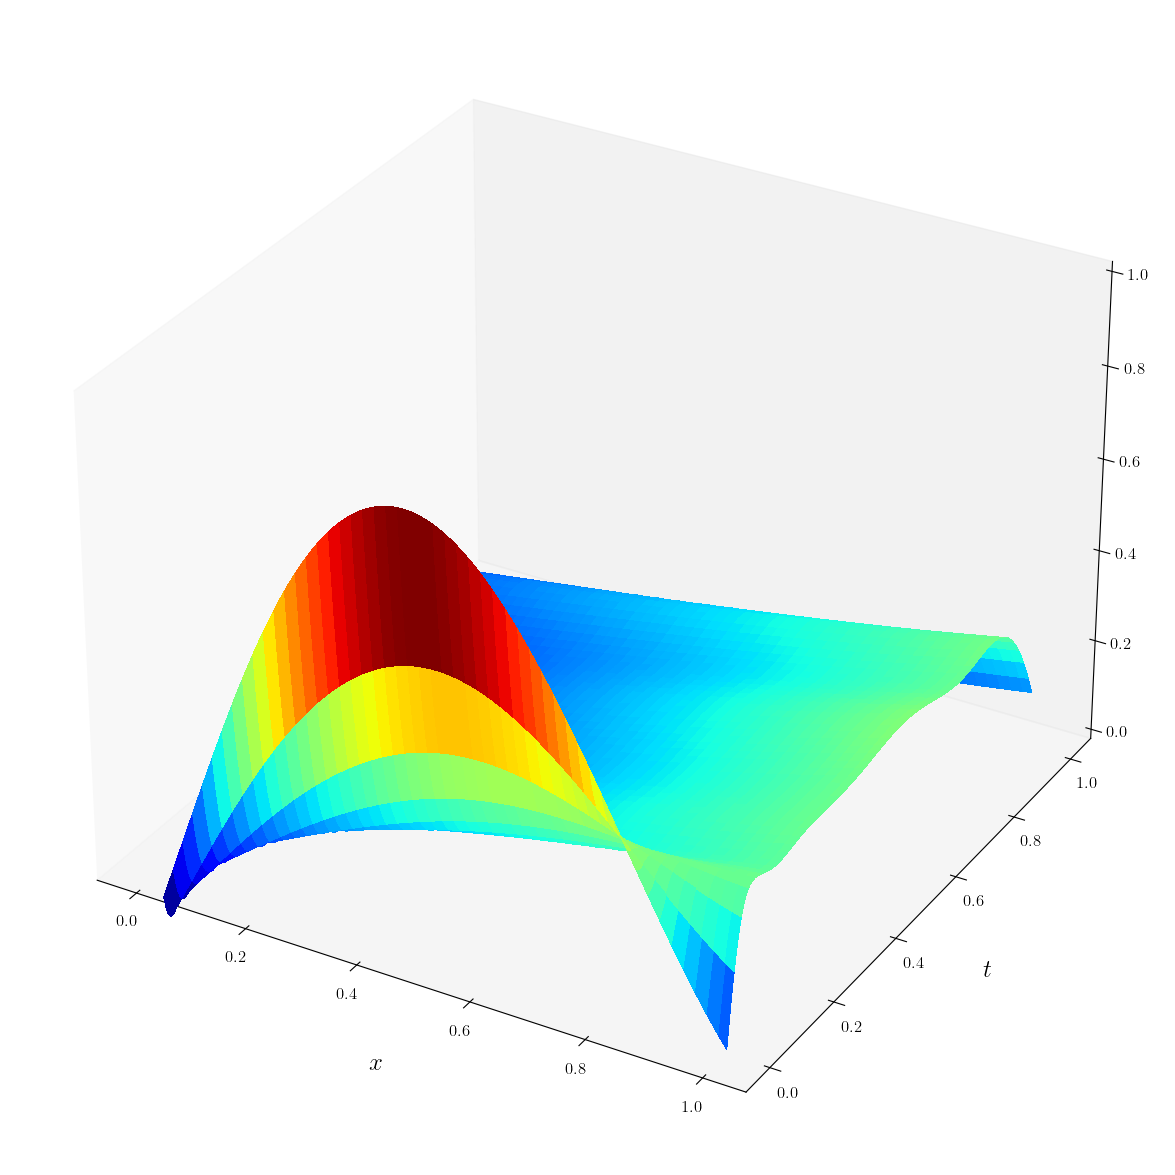

In [168]:
# Picture of z(x,t)

# Network evaluation
Nx, Nt = 200, 200  # Number of points for x ant t
x = np.linspace(0, L, Nx).reshape(-1, 1)
t = np.linspace(0, T, Nt).reshape(-1, 1)
X, T_grid = np.meshgrid(x, t)



xt_eval = np.hstack((X.flatten()[:, None], T_grid.flatten()[:, None]))
z_eval = psi_net.predict(xt_eval).reshape(Nt, Nx)

#delta = 1e-2
tf.reduce_all(z_eval >= 0.01)

# Visualization

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(X, T_grid, z_eval, cmap='jet', linewidth=0, antialiased=False)
ax.grid(False)
ax.set_zlim(0, 1)
ax.set_xlabel(r'$x$', fontsize=18, color="black", labelpad=20)
ax.set_ylabel(r'$t$', fontsize=18, color="black", labelpad=20)
#plt.savefig('../figures/state_z_linear_controlled_n_minus_1.pdf', format='pdf')
plt.show()



313/313 [==============================] - 0s 480us/step


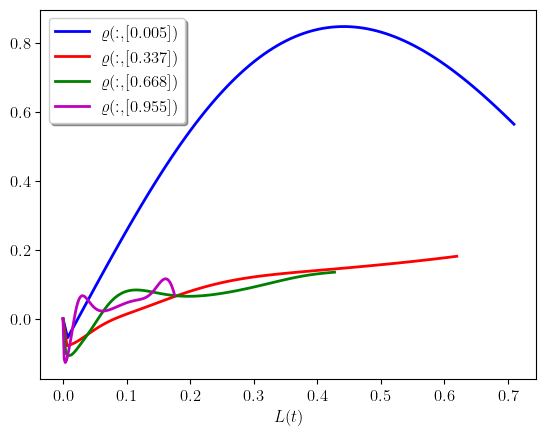

In [173]:
#T = 1
Nt_discrete = 100
Nx_discrete = 100
N_t = 200

k_eval = h_net(t).numpy()
L_eval = np.sqrt(k_eval)

discrete_time = np.array([t[1], t[67], t[133], t[190]])
y = np.array([L_eval[1], L_eval[67], L_eval[133], L_eval[190]])
xx_plot = np.zeros((4, Nx_discrete))
z_new = np.zeros((4, Nx_discrete))
for i in range(4):
    tt = np.linspace(0, discrete_time[i], Nt_discrete)     
    xx = np.linspace(0, y[i], Nx_discrete)
    xx_plot[i, :] = xx.T
    X_discrete, T_grid_discrete = np.meshgrid(xx, tt)
    xt_eval_discrete = np.hstack((X_discrete.flatten()[:, None], T_grid_discrete.flatten()[:, None]))
    z_eval_discrete = psi_net.predict(xt_eval_discrete)    
    
    for j in range(len(xx)):
        z_new[i, j] = z_eval_discrete[j * 101]
    
z_new[0, 0] = 0
z_new[1, 0] = 0
z_new[2, 0] = 0
z_new[3, 0] = 0
plt.figure()
plt.plot(xx_plot[0, :], z_new[0, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[0], 3)}' + r'$)$', linewidth=2, color='b')
plt.plot(xx_plot[1, :], z_new[1, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[1], 3)}' + r'$)$', linewidth=2, color='r')
plt.plot(xx_plot[2, :], z_new[2, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[2], 3)}' + r'$)$',linewidth=2, color='g')
plt.plot(xx_plot[3, :], z_new[3, :], label=r'$\varrho(:,$' +f'{np.round(discrete_time[3], 3)}' + r'$)$', linewidth=2, color='m')
plt.xlabel('$L(t)$')
plt.legend(framealpha=1, shadow=True)
plt.savefig('../figures/nonlinear_densities.pdf', format='pdf')
#plt.savefig('nonlinear_densities.eps', format='eps')




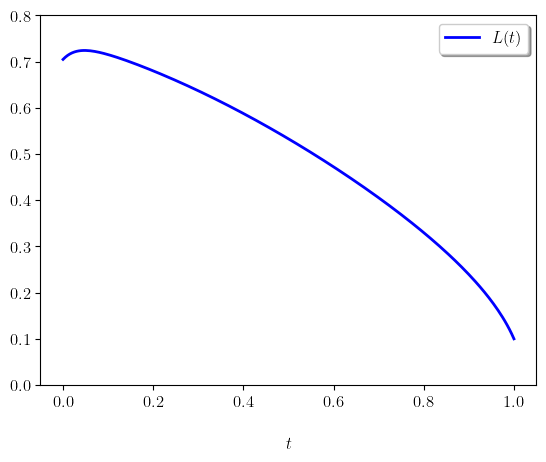

In [174]:

# Visualization 2D de L(t)
#L_eval = np.sqrt(k_eval)
plt.figure()
plt.plot(t, L_eval, label=r'$L(t)$', linewidth=2, color='blue')
plt.ylim(0, 0.8)
plt.xlabel(r'$t$', color="black", labelpad=20)
plt.legend(framealpha=1, shadow=True)
plt.savefig('../figures/nonlinear_state_L.pdf', format='pdf')
#plt.savefig('nonlinear_state_L.eps', format='eps')
plt.show()


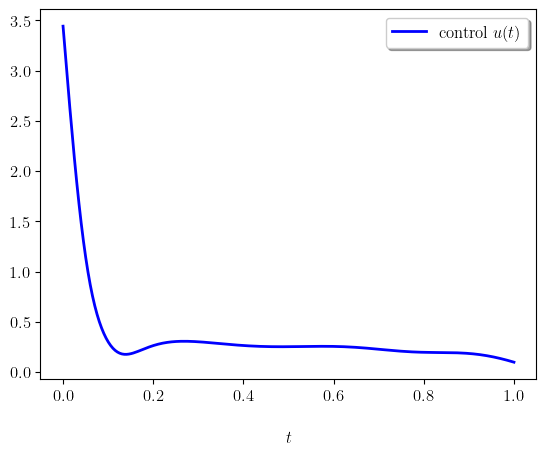

In [175]:
# Computation and visualization of z_x(0,t)
x_0_t_sample = tf.concat([tf.zeros_like(t), t], axis=1)
with tf.GradientTape() as tape2:
    tape2.watch(x_0_t_sample)
    z_pred_boundary = psi_net(x_0_t_sample)
    z_x_boundary = tape2.gradient(z_pred_boundary, x_0_t_sample)[:, 0:1]
tt = np.linspace(0, T, 200).reshape(-1, 1)
plt.figure()
plt.plot(tt, z_x_boundary, label='control $u(t)$', linewidth=2, color='blue')
plt.xlabel('$t$', color="black", labelpad=20)
plt.legend(framealpha=1, shadow=True)
plt.savefig('../figures/nonlinear_control_u.pdf', format='pdf')
#plt.savefig('nonlinear_control_u.eps', format='eps')
plt.show()